In [1]:
import bisect
import datetime as dt
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [18]:
def to_seconds(time_str):
    hr, mn, sec = map(int,time_str.split(':'))
    return sec + 60*mn + 3600*hr

In [29]:
stations_sched = {}
for i, line in enumerate(open('../Data/stop_times.txt')):
    if i != 0:
        trip_id, arrival, _, stop_id = line.strip().split(',')[:4]
        line = trip_id.split('_')[-1].split('.')[0]
        day = trip_id.split('_')[0][-3:]
        arrival = to_seconds(arrival)
        
        key = (line, stop_id)
        stations_sched.setdefault(key, set()).add(arrival)

In [31]:
lengths = []
for key in stations_sched.keys():
    lengths.append(len(stations_sched[key]))
print sorted(lengths)

[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 55, 55, 55, 57, 66, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69

In [32]:
def next_whole_minute(time):
    return time + 60 - (time % 60)

In [45]:
deltas_sched = []
next_subway_sched = []
next_subway_by_time_of_day_sched = [[] for x in xrange(24 * 60)] #one for each minute
next_subway_by_line_ts_sched = []
next_subway_by_line_ls_sched = []
next_subway_rush_hour_sched = []
max_limit = 4 * 3600 #4 hours

for key, values in stations_sched.iteritems():
    line, stop = key
    values = sorted(values)
    last_value = None
    for i in xrange(1,len(values)):
        last_value, value = values[i-1], values[i]
        if value - last_value >= max_limit: #more than 4 hours
            continue
        deltas_sched.append(1. / 60 * (value - last_value))
        for t in xrange(next_whole_minute(last_value), value, 60): #for each minute between last_value and value
            x = (t // 60 + 19 * 60) % (24 * 60) #convert to eastern time, remove date
            waiting_time = 1. / 60 * (value - t) #for arriving at minute t, the next train is value, so wait time is value - t
            next_subway_by_time_of_day_sched[x].append(waiting_time) #add wait time to that minute
            next_subway_sched.append(waiting_time) #general array of wait times
            next_subway_by_line_ts_sched.append(waiting_time) 
            next_subway_by_line_ls_sched.append(line) #which line does each wait time correspond to
            if x >= 7 * 60 and x < 19 * 60:
                next_subway_rush_hour_sched.append(waiting_time) #only wait times btwn 7am - 7pm 

In [46]:
percs = [50, 60, 70, 80, 90]
results = [[] for perc in percs]
xs = range(0, 24 * 60)
for x, next_subway_slice in enumerate(next_subway_by_time_of_day):
    if len(next_subway_slice) != 0:
        rs = np.percentile(next_subway_slice, percs)
    else:
        rs = np.percentile(0,percs)
    for i, r in enumerate(rs):
        results[i].append(r)

1440 1440
1440 1440
1440 1440
1440 1440
1440 1440


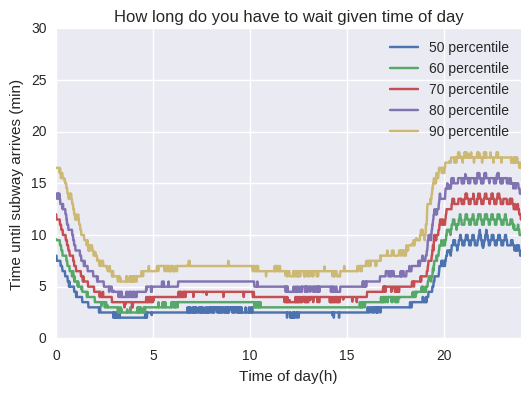

In [47]:
plt.clf()
for i, result in enumerate(results):
    print len(xs), len(result)
    plt.plot([x * 1.0 / 60 for x in xs], result, label='%d percentile'%percs[i])
plt.ylim([0,30])
plt.xlim([0,24])
plt.title('How long do you have to wait given time of day')
plt.xlabel('Time of day(h)')
plt.ylabel('Time until subway arrives (min)')
plt.legend()